# Tutorial for Searching a STAC Catalog

In this tutorial you will learn how to connect to a STAC API and search various datasets available for query. You will also search for specific items using a range of query parameters.  

We will use the [Earth Search API](https://www.element84.com/earth-search/) developed by Element84 for satellite datasets available on AWS S3 Storage (note that only those datasets that have a STAC catalog are served through this API). 
You can access the STAC catalog of the API [here](https://earth-search.aws.element84.com/v1). 

We will use the PySTAC Client for this tutorial. Check the documentation [here](https://pystac.readthedocs.io/en/stable/), and [these](https://pystac-client.readthedocs.io/en/latest/usage.html#itemsearch) specific guides about using ItemSearch

***Attribution***: Parts of this notebook are inspired by the great tutorial on **Access satellite imagery using Python** ([link](https://carpentries-incubator.github.io/geospatial-python/instructor/05-access-data.html#search-a-stac-catalog))

In [1]:
from pystac_client import Client

In [2]:
api_url = "https://earth-search.aws.element84.com/v1"

In [3]:
client = Client.open(api_url)

## Find Collections

First, we would like to see what collections are available from this API. 

In [4]:
collections = client.get_collections()

In [5]:
for collection in collections:
    print(collection)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


In order to get more information about a specific collection, you can use `get_collection` function:

In [6]:
s1_collection = client.get_collection("sentinel-1-grd")
s1_collection

<CollectionClient id=sentinel-1-grd>

## Search Items

Let's use Leafmap to select a point where we are interested to find a satellite imagery

In [7]:
import leafmap

In [8]:
m = leafmap.Map(center=[42.250809, -71.822833], zoom=16, height="800px")
m

Map(center=[42.250809, -71.822833], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Pan and zoom the map to find an area of interest, then use the tools on the top left of the map to select a point on the map. 


In [10]:
if m.user_rois is not None:
    point = m.user_rois['features'][0]['geometry']
else:
    point = dict(type="Point", coordinates=(42.250809, -71.822833))

We are interested to search for Sentinel-2 imagery that intersects with the point we selected in the previous step. So we will use the `search` function and insert `sentinel-2-l2a` as our collection of interest. We also use the `intersects` property to filter the scenes that intersect with our point of interest. 


In [11]:
search_results = client.search(
    collections=["sentinel-2-l2a"],
    intersects=point,
    max_items=12,
)

In [12]:
print(search_results.matched())

2619


The number that is returned in the previous step is more than 12 that we had identified in our search criteria. But this doesn't mean all the metadata about these scenes haven been retrieved. This just shows how many scenes have `matched` our search criteria. In the next cell, we will call `item_collection()` to retrieve the metadata, and check how many of them are retrieved. 

In [13]:
items = search_results.item_collection()

In [14]:
len(items)

12

Now, let's investigate an item

In [15]:
items[0]

<Item id=S2B_18TYM_20241005_0_L2A>

In [16]:
print(items[0].datetime)

2024-10-05 15:41:33.472000+00:00


In [17]:
print(items[0].geometry)

{'type': 'Polygon', 'coordinates': [[[-71.79389231083313, 42.407823796453954], [-72.10146774333118, 41.42723086104563], [-71.2944491287618, 41.4040441194201], [-71.23687622798481, 42.390872073839105], [-71.79389231083313, 42.407823796453954]]]}


We can now use the item's geometry and confirm that the returned scene intersects with our point of interest. 

In [18]:
m.add_geojson(items[0].geometry)
m

Map(bottom=1553450.0, center=[42.25123445095223, -71.79758548736574], controls=(ZoomControl(options=['position…

## Query Metadata

Items in STAC catalog have much more metadata (in addition to location) that you can query and only return results that match your query parameters. 
Let's use the `datetime` property and only search for scenes in 2024:

In [19]:
search = client.search(
    collections=["sentinel-2-l2a"],
    intersects=point,
    datetime="2024-01-01/2024-09-30"
)

In [20]:
print(search.matched())

217


Another property which is key for multispectral imagery is cloud cover; ideally we would be interested to find scenes with low cloud cover. Cloud cover is recorded in the metadata named `eo:cloud_cover`, and it ranges from 0 to 1. In the following, we are going to find scenes that only have a cloud cover of less than 5% in 2024.

In [21]:
search = client.search(
    collections=["sentinel-2-l2a"],
    intersects=point,
    datetime="2024-01-01/2024-09-30",
    query=["eo:cloud_cover<5"],
    max_items=10
)

In [22]:
print(search.matched())

28


Another useful property of the STAC API is that you can sort the results using a metadata property. For example, let's sort our results based on the cloud cover value:

In [23]:
search = client.search(
    collections=["sentinel-2-l2a"],
    intersects=point,
    datetime="2024-01-01/2024-09-30",
    query=["eo:cloud_cover<5"],
    sortby=["+properties.eo:cloud_cover"],
    max_items=10
)

In [24]:
items = search.item_collection()

In [25]:
len(items)

10

In [26]:
for item in items:
    print(item.properties["eo:cloud_cover"])

0.002757
0.003209
0.00352
0.003534
0.005557
0.00576
0.009869
0.01449
0.020466
0.021576


You can also save the results of the search into a JSON file if you need it later on. 

In [27]:
items.save_object("search.json")

## Access Assets

Next, we will use the assets of the returned items and retrieve the actual scene. 

In [28]:
#Let's look at the second item:
selected_item = items[4]

In [29]:
# Here are the assets available for this item
assets = selected_item.assets
print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


In [30]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

Each asset has a link which can be accessed from the `href` property. This can be a HTTP URL or a link to S3 for this STAC catalog. For example, let's look at the link for the thumbnail of the scene.  

In [31]:
print(assets["thumbnail"].href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/19/T/BG/2024/9/S2A_19TBG_20240913_0_L2A/thumbnail.jpg


Since this is a HTTP link, we can use Python requests package to load the image. 

In [32]:
import requests
img_data = requests.get(assets["thumbnail"].href).content

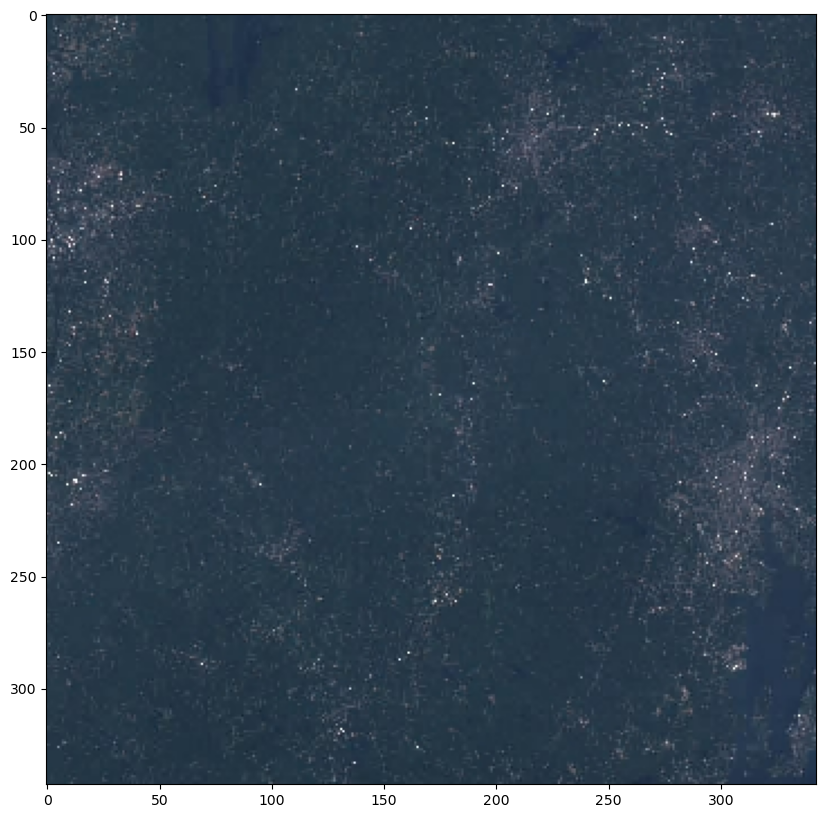

In [33]:
import matplotlib.pyplot as plt
from PIL import Image
import io
plt.figure(figsize=(10, 10))
plt.imshow(Image.open(io.BytesIO(img_data)))

Now, let's load one of the COG assets into memory. This is a large scene, and we don't necessary want to load all the data at once. There are various packages to do this. Here we will use `rioxarray`, you can also use [`stacstack`](https://stackstac.readthedocs.io/en/latest/) and [`odc-stac`](https://odc-stac.readthedocs.io/).

In [34]:
import rioxarray

In [35]:
nir_href = assets["nir"].href
nir = rioxarray.open_rasterio(nir_href)
nir

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2e+05 2e+05 2e+05 ... 3.098e+05 3.098e+05 3.098e+05
  * y            (y) float64 4.7e+06 4.7e+06 4.7e+06 ... 4.59e+06 4.59e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

**Note**: At this stage the `nir` DataArray that we defined is empty, and only the metadata of the scene is loaded from the target href. This is consistent with `open_rasterio` function behavior, and you will learn more about it later in the class. 
When you run any function on `nir` or call any of the built-in function (e.g. `mean()`) the data will be loaded to memory. 

First, let's plot part of the `nir` array. 

In [36]:
import matplotlib.pyplot as plt

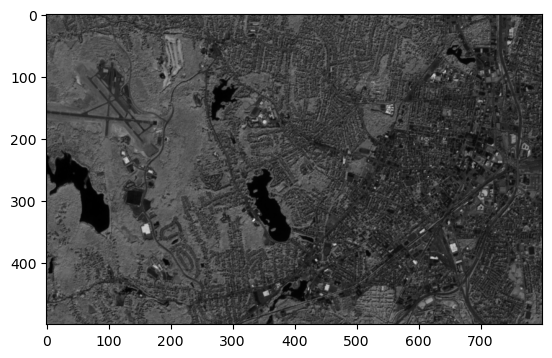

In [37]:
plt.imshow(nir[0,1500:2000,6200:7000], cmap='gray')

In this case, only the portion of the array that we wanted to visualize was loaded. 

We can actually time the operation of plotting the whole scene vs the small portion we selected, and see the efficiency of using this approach. 

5.78 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


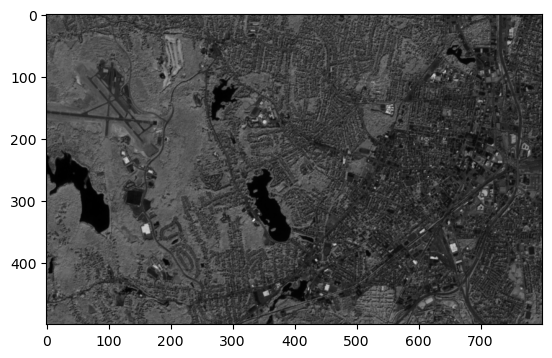

In [38]:
%%timeit -n 5 -r 1
plt.imshow(nir[0,1500:2000,6200:7000], cmap='gray')

18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


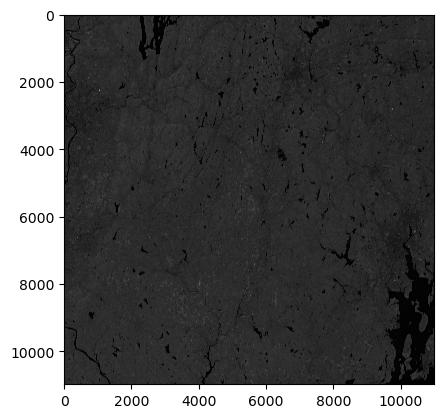

In [39]:
%%timeit -n 5 -r 1
plt.imshow(nir[0, :, :], cmap='gray')

Lastly, you can save this array into a GeoTIFF file as following:

In [40]:
nir[0,1500:2000,6200:7000].rio.to_raster("nir_subset.tif")